In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

# Introduction to sampling

In this notebook, we'll give a short introduction to sampling from a posterior probability distribution. 

This problem is quite straight forward and could be solved by just evaluating the posterior on a grid, or even analytically. Nevertheless, its useful example for when things get more complicated and we can't do that!

This example is loosely based on [this post by Thomas Weicki](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)

## Setting up the problem

Consider a situation where we have data $\mathbf{d} = \{d_1, d_2, \ldots, d_N\}$. We bin it in a histogram and it looks like this:

In [2]:
N = 30  # Number of data points
data = np.random.normal(0, 1, N)  # Generate the fake data
print(data)

[ 1.71861771e+00  1.53051964e+00  6.36043382e-01  9.49703648e-01
  2.48237624e-01  1.22638445e+00  5.71576629e-01 -8.27326555e-01
  4.33485400e-05  1.86217868e+00  1.05036010e-01 -3.78720108e-01
  1.96172019e-01  1.48989786e-01 -7.08256663e-01 -8.31872225e-01
  7.11062265e-03 -1.13844655e-01 -6.63853656e-01 -1.26635472e+00
 -8.79306497e-01  3.17465037e-01  5.35195610e-03  7.09984882e-01
 -1.86849591e+00  9.00482292e-01  1.57668021e+00  9.63613582e-01
 -2.89055566e-01 -7.61292148e-01]


<IPython.core.display.Javascript object>


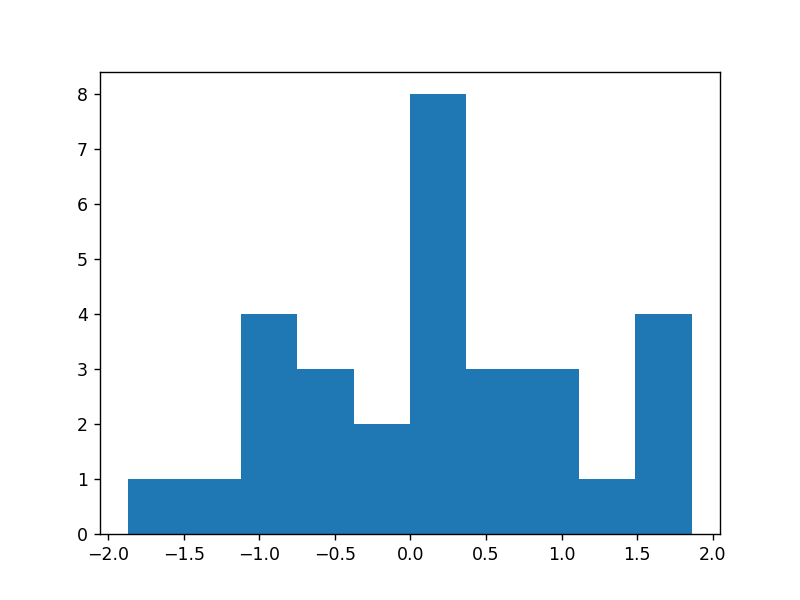

In [3]:
fig, ax = plt.subplots()
ax.hist(data)
plt.show()

This data is quite abstract, but it could be anything, e.g.,

* Height of people in a population, or
* Measurement error of an experiment.

The specifics aren't too important. What we are interested in is

> ** if we model the observed data as normally distributed, but with unknown mean, how can we infer what the mean is from the data? **

Note - we'll be assuming we *know* the standard deviation $\sigma=1$ in the rest of this example.

Mathematically, this corresponds to find the posterior distribution $ P(\mu| \mathbf{d})$ where $\mu$ is the mean:

$$ P(\mu| \mathbf{d}) = \frac{P(\mathbf{d}| \mu) P(\mu)}{P(\mathbf{d})} $$

For now, we are only interested in the relative probabilities of the different $\mu$ values so we can drop the normalization:

$$ P(\mu| \mathbf{d}) \propto P(\mathbf{d}| \mu) P(\mu)$$

Finally, we'll now make an assumption that all the data are independent. This means we can do the following

$$ P(\mathbf{d}| \mu) = \prod_{i=1}^N P(d_i | \mu) $$

## Putting the model into the story

So far we have been quite abstract and it may not be clear yet how to evaluate the posterior. However, we need to recognise our generative model for the data:

> the data is generated from a Normal distribution

This means that we can test how *likely* the $i$th data point is by plugging it into a standard Normal distribution:

$$ P(d_i| \mu) = \mathrm{Normal}(d_i; \mu) = \frac{1}{\sqrt{2\pi}} \mathrm{exp}\left(\frac{-(d_i - \mu)^2}{2}\right)$$

*Note - there is no $\sigma$ here as we set it to be $\sigma=1$, this is known as a standard Normal distribution*

Let's write a python function to evaluate our likelihood

In [4]:
def likelihood(data, mu):
    """ Likelihood of the data (a vector), given mu """
    likelihood_per_di = np.exp(-(data - mu)**2 / 2) / np.sqrt(2*np.pi)
    return np.prod(likelihood_per_di)

### Priors
The final thing left need to evaluate the unormalised posterior is the prior. In this case, we'll use a Uniform prior over a suitable range:

$$ P(\mu) = \mathrm{Uniform}(-10, 10) = \begin{array}{cc}
\frac{1}{20} & \mathrm{if} -10 \leq \mu < 10 \\
0 & \mathrm{otherwise} \end{array}$$

Let's write a python function to evaluate our prior

In [5]:
def prior(mu):
    """ Prior for mu"""
    if (-10 <= mu) and mu < 10:
        return 1/20.
    else:
        return 0

## Sampling from the posterior: hill climbing

We'll now describe what is meant by sampling. Firstly, in a simple "hill climbing" context (you'll see why it's called this in a moment). 

The basic idea is we are going to "walk" around the parameter space. First, let's pick somewhere to start.

In [6]:
mu_current = 1

Next, we'll decide how to "walk"

In [7]:
proposal_std_dev = 0.1
proposal = np.random.normal(0, proposal_std_dev)
print(proposal)

-0.0531138894783


Now, we propose a step

In [8]:
mu_proposal = mu_current + proposal
print(mu_proposal)

0.946886110522


At this point, we have two "positions" in $\mu$-space. We need a way to decide between them. We'll do this by computing the unnormalised posterior probability of both

In [9]:
likelihood_current = likelihood(data, mu_current)
prior_current = prior(mu_current)
p_current = likelihood_current * prior_current
print(p_current)

6.349756796593056e-24


In [10]:
likelihood_proposal = likelihood(data, mu_proposal)
prior_proposal = prior(mu_proposal)
p_proposal = likelihood_proposal * prior_proposal
print(p_proposal)

2.2860021966244462e-23


Okay these are tiny numbers! But, we can take a ratio and, if the proposal is larger than the current step, that is "up hill", i.e. that value of $\mu$ is more probable than the current one.

We can repeat this process to build a very simply hill walking climber with just this logic. Let's have a look at what that does. So that you can play around with it elsewhere, we will put it into a function:

In [11]:
def hill_walker(mu_init, nsamples=100, proposal_std_dev=0.01):
    mu_current = mu_init
    mu_values = [mu_current]
    for n in range(nsamples):
        # Propose a new step and compute the probabilities
        proposal = np.random.normal(0, proposal_std_dev)
        mu_proposal = mu_current + proposal
        likelihood_current = likelihood(data, mu_current)
        prior_current = prior(mu_current)
        p_current = likelihood_current * prior_current

        likelihood_proposal = likelihood(data, mu_proposal)
        prior_proposal = prior(mu_proposal)
        p_proposal = likelihood_proposal * prior_proposal

        # If the proposed step is better than the current, p_accept > 1 so we accept it
        p_accept = p_proposal / p_current
        if p_accept > 1:
            mu_current = mu_proposal
        mu_values.append(mu_current)
        
    return mu_values

Running it for 100 steps and plotting the output

<IPython.core.display.Javascript object>


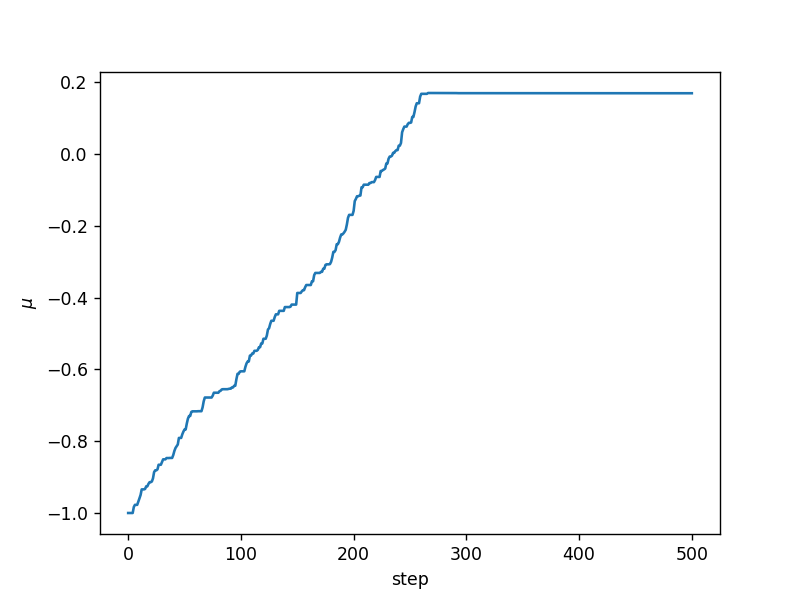

In [12]:
mu_values = hill_walker(mu_init=-1, nsamples=500)
fig, ax = plt.subplots()
ax.plot(mu_values)
ax.set_xlabel('step')
ax.set_ylabel('$\mu$')
plt.show()

Okay, this is great. It's telling us that the top of the hill (or the peak of the posterior) is near to 0.1 or so. But, this isn't sampling from the posterior. Eventually the walker will find the peak (to within numerical accuracy) and no more proposals will be accepted.

## Sampling from the posterior

To sample from the posterior, we need to sometimes take a step downwards. We can do this by changing one line of our hill walker from

```python 
if p_accept > 1:
```

to 
```python 
if p_accept > np.random.uniform(0, 1):
```

#### What does this do?

`np.random.uniform(0, 1)` returns a (psuedo) random number uniformly distributed between 0 and 1, for example

In [13]:
np.random.uniform(0, 1)

0.9641079661069669

The results is that

* if `p_accept > 1` then we will always accept the move (we found a better point to move to)
* but, if `p_accept < 1` we will **sometimes** move there

### The maths

What is `p_accept` really? Well, if we call $\mu_c$ the current value and $\mu_p$ the proposed value

$$ \texttt{p_accept} = 
\frac{P(\mathbf{d} | \mu_c) P(\mu_c)}{P(\mathbf{d} | \mu_p) P(\mu_p)} =
\frac{
\frac{P(\mathbf{d} | \mu_c) P(\mu_c)}{P(\mathbf{d})}
}{
\frac{P(\mathbf{d} | \mu_p) P(\mu_p)}{P(\mathbf{d})}
}
=\frac{P(\mu_c| \mathbf{d})}{P(\mu_p| \mathbf{d})}
$$

So `p_accept` is the ratio of probabilities at two different points (it's  convienient that the normalisation, which we often can't compute, happens to drop out).

Let's implement this and see the difference

In [14]:
def sampler(mu_init, nsamples=100, proposal_std_dev=0.05):
    mu_current = mu_init
    mu_values = [mu_current]
    
    nacceptance = 0
    for n in range(nsamples):
        # Propose a new step and compute the probabilities
        proposal = np.random.normal(0, proposal_std_dev)
        mu_proposal = mu_current + proposal
        likelihood_current = likelihood(data, mu_current)
        prior_current = prior(mu_current)
        p_current = likelihood_current * prior_current

        likelihood_proposal = likelihood(data, mu_proposal)
        prior_proposal = prior(mu_proposal)
        p_proposal = likelihood_proposal * prior_proposal

        # If the proposed step is better than the current, p_accept > 1 so we accept it
        p_accept = p_proposal / p_current
        if p_accept > np.random.uniform(0, 1):
            mu_current = mu_proposal
            nacceptance += 1  # This is just keeping track of how many times proposals where accepted.
        mu_values.append(mu_current)
        
    print('Finished, acceptance ratio = {}'.format(nacceptance/nsamples))
        
    return mu_values

Finished, acceptance ratio = 0.93


<IPython.core.display.Javascript object>


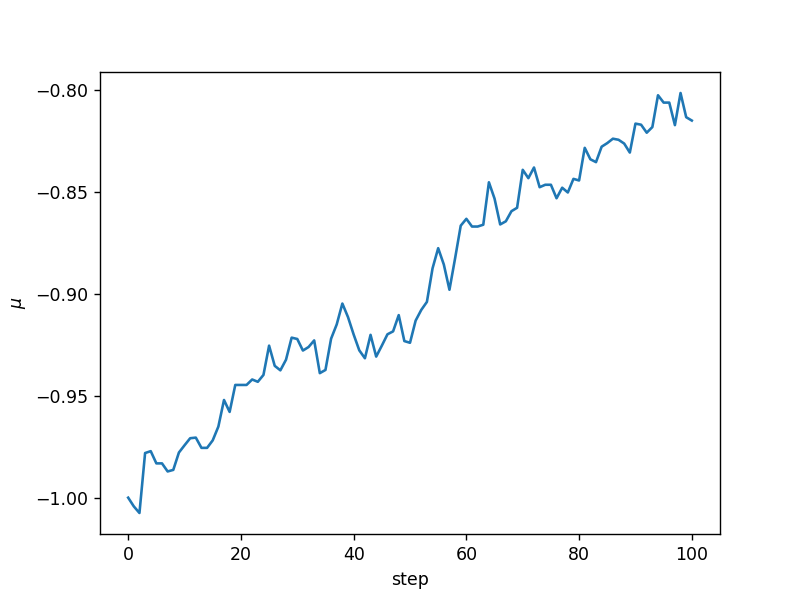

In [15]:
mu_values = sampler(mu_init=-1, nsamples=100, proposal_std_dev=0.01)
fig, ax = plt.subplots()
ax.plot(mu_values)
ax.set_xlabel('step')
ax.set_ylabel('$\mu$')
plt.show()

Let's see what happens when we get lots of samples

Finished, acceptance ratio = 0.9831


<IPython.core.display.Javascript object>


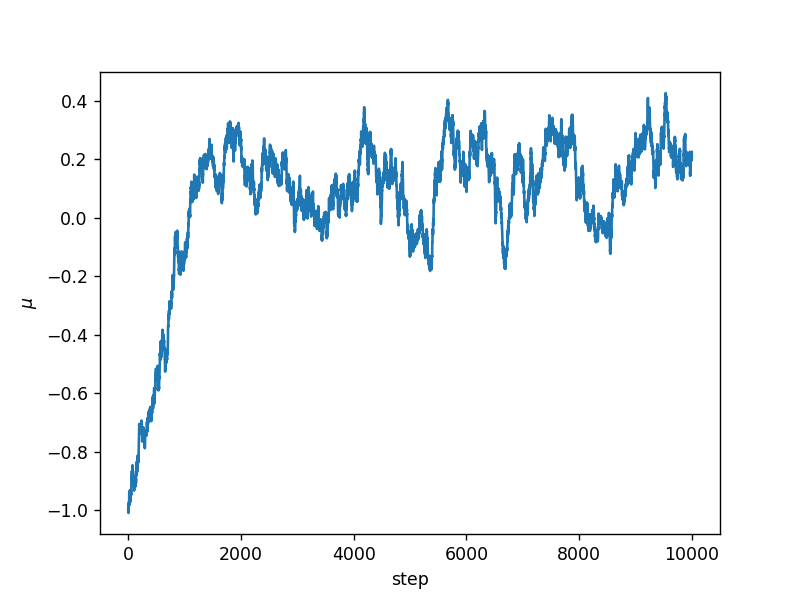

In [16]:
mu_values = sampler(mu_init=-1, nsamples=10000, proposal_std_dev=0.01)
fig, ax = plt.subplots()
ax.plot(mu_values)
ax.set_xlabel('step')
ax.set_ylabel('$\mu$')
plt.show()

and even more

Finished, acceptance ratio = 0.98238


<IPython.core.display.Javascript object>


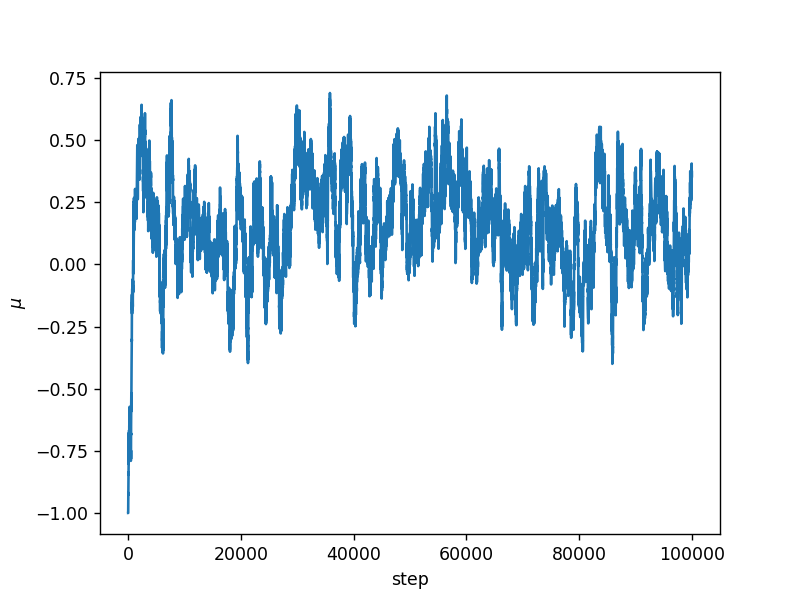

In [17]:
mu_values = sampler(mu_init=-1, nsamples=100000, proposal_std_dev=0.01)
fig, ax = plt.subplots()
ax.plot(mu_values)
ax.set_xlabel('step')
ax.set_ylabel('$\mu$')
plt.show()

It looks like it is jumping around back and forth. Let's histogram these samples

<IPython.core.display.Javascript object>


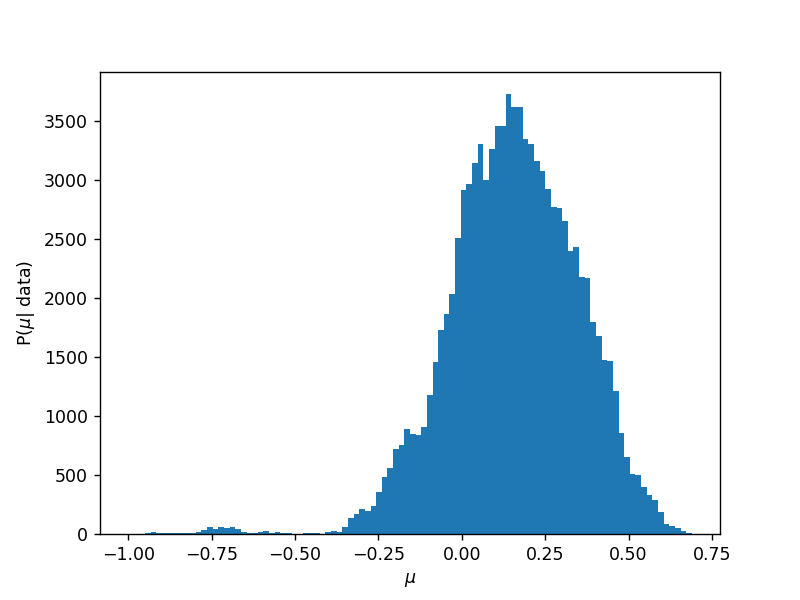

In [18]:
fig, ax = plt.subplots()
out = ax.hist(mu_values, bins=100)
ax.set_xlabel('$\mu$')
ax.set_ylabel('P($\mu$| data)')
plt.show()

This looks like a posterior distribution and it is (sort of). 

We have written a (basic) [Metropolis Hasting Marcov-Chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) sampler. These samplers satisfy a condition known as [detailed balance](https://en.wikipedia.org/wiki/Detailed_balance), which means that 

> ** in the limit of taking a sufficiently large number of samples, the distribution of the samples approximates that of the distribution itself **. 

However, as you'll note there are several issues with this posterior! Let's go through them

## Problems

### Auto correlation

Let's take a look at some of the samples closely

<IPython.core.display.Javascript object>


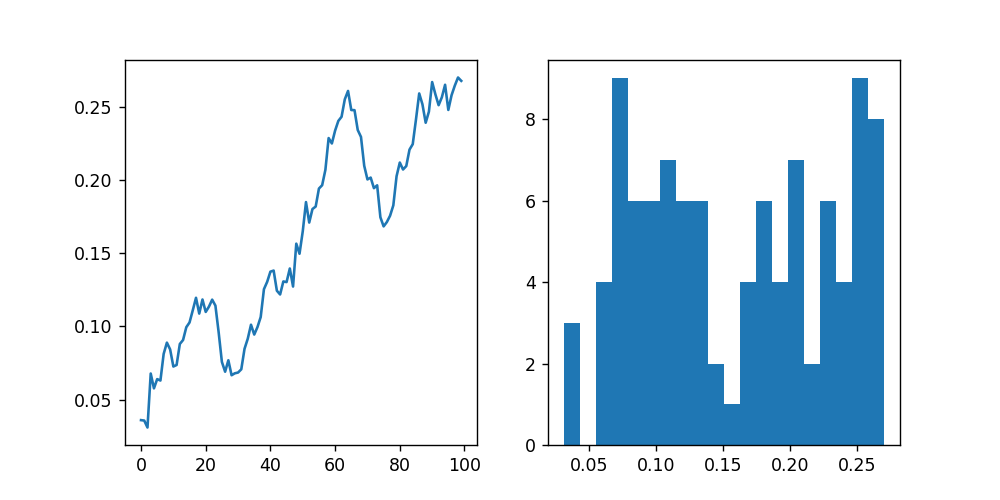

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
ax1.plot(mu_values[5000:5100])
out = ax2.hist(mu_values[5000:5100], bins=20)

These don't look like indepedent draws from the posterior at all! This is because the samples are **correlated**. We can see this by looking at the estimated autocorrelation function

<IPython.core.display.Javascript object>


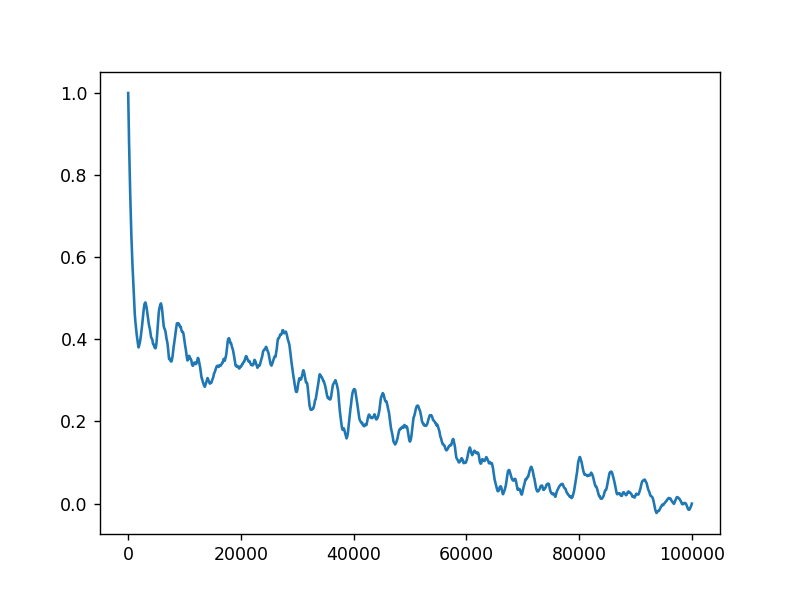

In [20]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result = result / result[result.size//2]
    return result[result.size//2:]

rho = autocorr(mu_values)
fig, ax = plt.subplots()
ax.plot(rho)
plt.show()

There are some great notes by [Alan Sokal](http://www.stat.unc.edu/faculty/cji/Sokal.pdf) on this topic (for general Markov Chains). One take away message that you should always keep in your head when looking at MCMC output is that 

> ** the number of efectively independent samples in a run of length n is roughly **

$$ \frac{n}{2\tau} = \frac{\textrm{Number of samples in the MCMC walk}}{2 \times \textrm{integrated autocorrelation
time}} $$ 

The integrated autocorrelation time is defined in those notes.

Estimating the autocorrelation time is not easy, luckily the authors of [`emcee`](http://dfm.io/emcee/current/) have provided a useful interface we can use (also see the nice discussion [here](http://emcee.readthedocs.io/en/latest/tutorials/autocorr/)). Here we use that function to estimate the autocorrelation time of our chain.

In [21]:
import emcee
tau = emcee.autocorr.integrated_time(np.array(mu_values), c=2)
print(tau)

1069.3956321649914


Note - you can install `emcee` with `$ pip install emcee`.

So for our samples, how many independent samples do we have?

In [22]:
len(mu_values) / (2 * tau)

46.7558483465787

That is not very many.. it might be tempting to just run the sampler for longer. But first, let's look at how we generated the samples.

### Proposal distrtibution

You'll have seen throughout the previous examples that set `proposal_std_dev=0.01`. This variable decides how new jumps are proposed. Choosing this value is a balance:

* If it is **too small** then the sampler will be inefficient, taking a long time to explore the space (with many calls to the likelihood and prior), but few of these will be independent.
* On the other hand, if it is **too large** then few proposals will be accepted - it will spend must of the time jumping away from the posterior. 

One metric to help with this is the *acceptance fraction*, i.e., the number or proposed jumps that where accepted. You'll notice we have been printing this after each run and it was typically around `0.9` (indicating that `proposal_std_std` is too small).

Let's increase it, we ideally (for this sampler) will aim for an acceptance fraction of 0.5

Finished, acceptance ratio = 0.3557


<IPython.core.display.Javascript object>


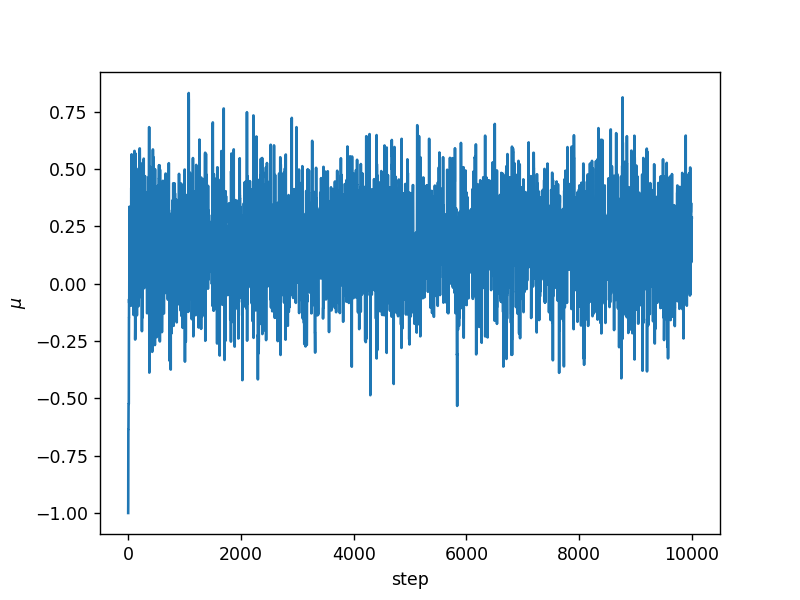

In [23]:
mu_values = sampler(mu_init=-1, nsamples=10000, proposal_std_dev=0.6)
fig, ax = plt.subplots()
ax.plot(mu_values)
ax.set_xlabel('step')
ax.set_ylabel('$\mu$')
plt.show()

That looks betters, now calculate the autocorrelation time and number of independent samples

In [24]:
tau = emcee.autocorr.integrated_time(np.array(mu_values), c=2)
n_independent_samples = len(mu_values) / (2 * tau)
print(tau, n_independent_samples)

4.916083419207638 1017.1715110574686


This looks much better. Note that if you want to discard correlated samples you can **thin**:

In [25]:
thinned_samples = mu_values[::int(tau)]
print(len(thinned_samples))

2501


### Burn-in

Firstly, MCMC-samplers can suffer from a problem known as *burn-in*. This is the effect of the initialisation of the chain (which is usually chosen arbitrarily) on the posterior. Let's exagerate this effect by using a small proposal_std_dev to make it clear:

Finished, acceptance ratio = 0.9054


<IPython.core.display.Javascript object>


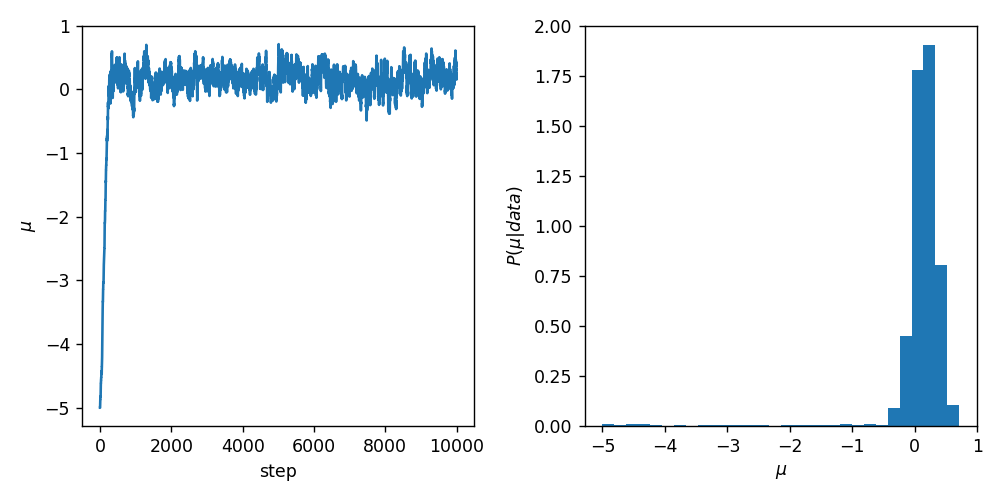

/home/user1/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [26]:
mu_values = sampler(mu_init=-5, nsamples=10000, proposal_std_dev=0.05)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
ax1.plot(mu_values)
ax1.set_xlabel('step')
ax1.set_ylabel('$\mu$')

ax2.hist(mu_values, bins=30, normed=True)
ax2.set_xlabel('$\mu$')
ax2.set_ylabel('$P(\mu| data)$')
plt.tight_layout()
plt.show()

Here we see that there is a "tail" from the fact that the chain was started quite far away from the posterior. One easy way to deal with this is to remove the first few hundred steps (or more precisely, a few times the autocorrelation length, of which more later) from the chain before generating the posterior.

Finished, acceptance ratio = 0.9003


<IPython.core.display.Javascript object>


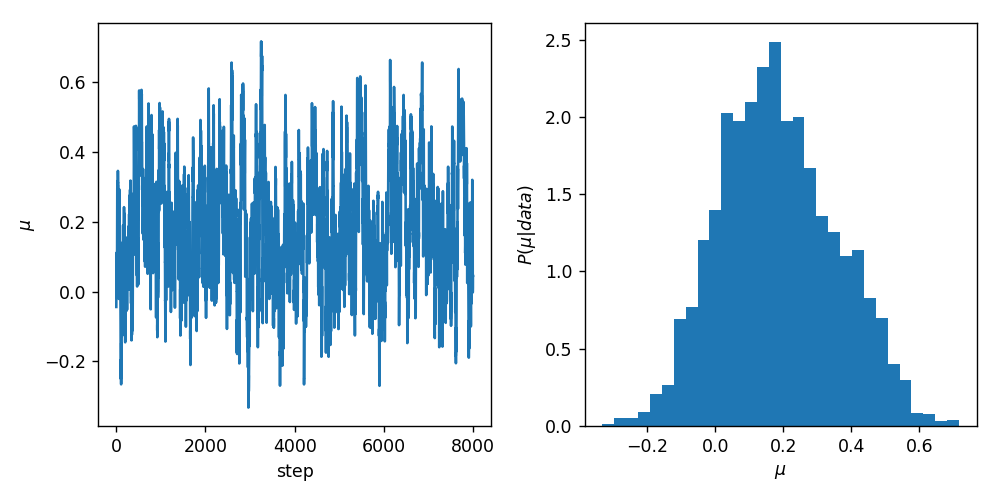

In [27]:
nburn = 2000
mu_values = sampler(mu_init=-5, nsamples=10000, proposal_std_dev=0.05)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
ax1.plot(mu_values[nburn:])
ax1.set_xlabel('step')
ax1.set_ylabel('$\mu$')

ax2.hist(mu_values[nburn:], bins=30, normed=True)
ax2.set_xlabel('$\mu$')
ax2.set_ylabel('$P(\mu| data)$')
plt.tight_layout()
plt.show()

## Putting it all together

Okay, so let's fix all the aforementioned problems and look at the posterior:

Finished, acceptance ratio = 0.34694


<IPython.core.display.Javascript object>


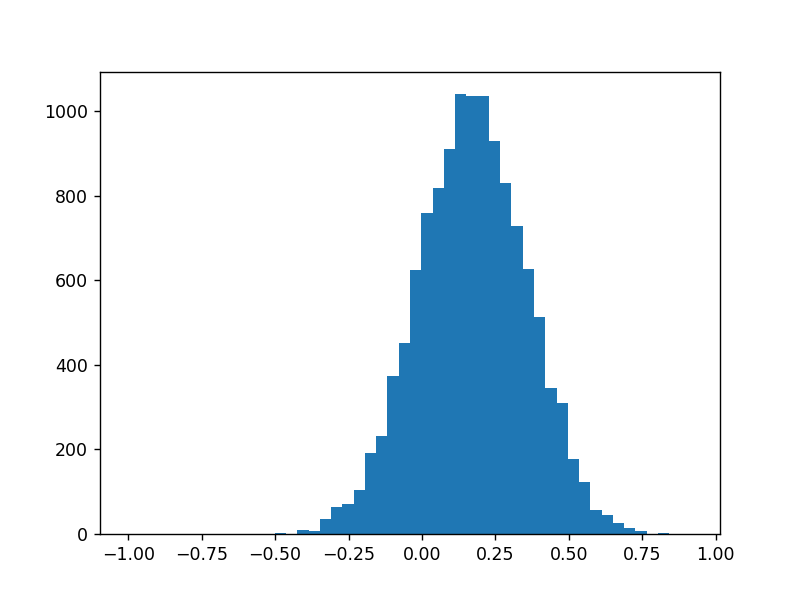

In [28]:
mu_values = sampler(mu_init=-1, nsamples=50000, proposal_std_dev=0.6)  # Generate samples
tau = int(emcee.autocorr.integrated_time(np.array(mu_values), c=2))  # Calculate tau
mu_values = mu_values[tau:]  # Drop the first tau samples (the burn-in)
mu_values = mu_values[::tau]  # Thin the samples by tau

fig, ax = plt.subplots()
out = ax.hist(mu_values, bins=50)
plt.show()

## Extension ideas/challenges

* Implement non-uniform priors, what does this do?
* Increase the number of data points and rerun the sampler. You'll find that it breaks, why?
* Try implementing log-probabilities rather than the probabilities themselves.
* Write down your own problem and make a simple sampler.